# Spoiler alert! 🎥 Abstractive movie reviews Summarization with Claude, Cohere and Chain of Density 🎥

> Also: bigger models are not always better!


In [2]:
%pip install --quiet \
    langchain==0.0.309 \
    "transformers>=4.24,<5" \
    sqlalchemy -U \
    "faiss-cpu>=1.7,<2" \
    "pypdf>=3.8,<4" \
    pinecone-client \
    apache-beam \
    datasets \
    tiktoken \
    "ipywidgets>=7,<8" \
    matplotlib \
    boto3 \
    chromadb==0.4.15 \
    langchainhub


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Objective

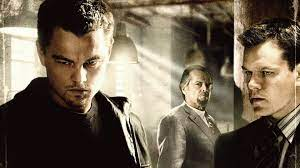

The objective of this notebook is to highlight how we can work with state-of-the-art prompt design and be familiarized with two Bedrock models (Anthropic and Cohere), while digging deeper on summarization use-case

## Summarizing long text

In [9]:
from langchain.llms.bedrock import Bedrock
import boto3

bedrockruntime = boto3.client('bedrock-runtime')

modelId = 'anthropic.claude-v2' #
llm = Bedrock(
    model_id=modelId,
    model_kwargs={
        "top_p": 1,
        "stop_sequences": ["\n\nHuman:"],
           "max_tokens_to_sample":10000
    },
    client=bedrockruntime,
)

## Loading movie reviews

We generated 2 movies reviews:

- _The Good, the bad and the ugly_
- _The Departed_

In [5]:
import json
with open('./data/good_bad_ugly.json') as fp:
    d=json.loads(fp.read())
reviews = d['reviews']

Let's review an example of such a review

In [74]:
from IPython.display import display, Markdown

display(Markdown(json.dumps(reviews[0])))


{"review_id": 1, "rating": 5, "author": "Cinephile123", "text": "The Departed is a masterpiece of crime cinema. Martin Scorsese's direction is nothing short of brilliant, and the film's stellar cast, including Leonardo DiCaprio, Matt Damon, and Jack Nicholson, deliver outstanding performances. The cat-and-mouse game between the Boston police and the mob keeps you on the edge of your seat throughout. The film's tension and suspense are perfectly balanced with moments of dark humor. It's a crime thriller that stands the test of time."}

## Store documents to be compatible with Langchain

In [10]:
from langchain.docstore.document import Document
docs= []
for review in reviews:
    md = review.copy()
    md.pop('text')
    md['nb_tokens']=llm.get_num_tokens(review['text'])
    doc = Document(page_content=review['text'], metadata=md)
    docs.append(doc)

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [11]:
num_docs = len(docs)

num_tokens_first_doc = llm.get_num_tokens(docs[0].page_content)

display(Markdown(
    f"Now we have {num_docs} documents and the first one has {num_tokens_first_doc} tokens"
))

Now we have 10 documents and the first one has 156 tokens

### Summarizing chunks and combining them

Assuming that the number of tokens is consistent in the other docs we should be good to go. Let's use LangChain's [load_summarize_chain](https://python.langchain.com/en/latest/use_cases/summarization.html) to summarize the text. `load_summarize_chain` provides three ways of summarization: `stuff`, `map_reduce`, and `refine`.
- `stuff` puts all the chunks into one prompt. Thus, this would hit the maximum limit of tokens.
- `map_reduce` summarizes each chunk, combines the summary, and summarizes the combined summary. If the combined summary is too large, it would raise error.
- `refine` summarizes the first chunk, and then summarizes the second chunk with the first summary. The same process repeats until all chunks are summarized.

`map_reduce` and `refine` invoke LLM multiple times and takes time for obtaining final summary.
Let's try `map_reduce` here.

In [12]:
# Set verbose=True if you want to see the prompts being used
from langchain.chains.summarize import load_summarize_chain
summary_chain = load_summarize_chain(llm=llm, chain_type="stuff", verbose=True)

> ⏰ **Note:** Depending on your number of documents, Bedrock request rate quota, and configured retry settings - the chain below may take some time to run.

In [13]:
output = ""
try:

    output = summary_chain.run(docs)

except ValueError as error:
    if  "AccessDeniedException" in str(error):
        print(f"\x1b[41m{error}\
        \nTo troubeshoot this issue please refer to the following resources.\
         \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
         \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")
        class StopExecution(ValueError):
            def _render_traceback_(self):
                pass
        raise StopExecution
    else:
        raise error



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"The Good, the Bad and the Ugly is, without a doubt, a pinnacle of cinematic achievement. Sergio Leone's direction in this film is nothing short of visionary. The way he utilizes the vast, arid landscapes to create a sense of both isolation and grandeur is masterful. Ennio Morricone's score is a character in itself, evoking emotions that words alone cannot express. Clint Eastwood's portrayal of the 'Man with No Name' is iconic, displaying a stoic coolness that defines a generation of anti-heroes. The film's final standoff is a tense, nail-biting climax, and the way it's shot, with extreme close-ups and drawn-out silences, keeps you on the edge of your seat.

Sergio Leone's The Good, the Bad and the Ugly stands as a monumental achievement in the realm of spaghetti westerns. The film is a captivating journey through the unforgiving and lawl

In [14]:

display(Markdown(output.strip()))

The Good, the Bad and the Ugly is widely considered a landmark spaghetti western. Director Sergio Leone utilized innovative cinematography and direction to capture the essence of the lawless American frontier. Ennio Morricone's iconic score amplifies the film's atmosphere and tension. Clint Eastwood's "Man with No Name" character is an enduring cinema anti-hero. However, reactions are mixed regarding the film's lengthy runtime. Some consider it an undisputed masterpiece, while others find it overly long despite respecting its technical achievements. Overall, The Good, the Bad and the Ugly showcases Leone's unique directorial vision and remains a defining film of the western genre.

## Trying Chain of Density

#### CoD in a nutshell


Summarizing is a hard task. [Chain of Density](https://arxiv.org/pdf/2309.04269.pdf) put guardrails into summarization prompting. Technically speaking, it is a series of chained prompts aimed at finding a trade-off between informativeness and readability of a summary.


The prompt itself is quite trivial at its atomic basis:
- finding informative entities from the text we'd want to familiarize that are not found yet
- write a summary over the new entities found in the article.

In the article, __the process is repeated over 5 times__.


#### What is a missing entity?

From the article's advised prompt:

> " A missing entity is:
- relevant to the main story,
- specific yet concise (5 words or fewer),
- novel (not in the previous summary),
- faithful (present in the reviews),
- anywhere (can be located anywhere in the review)."

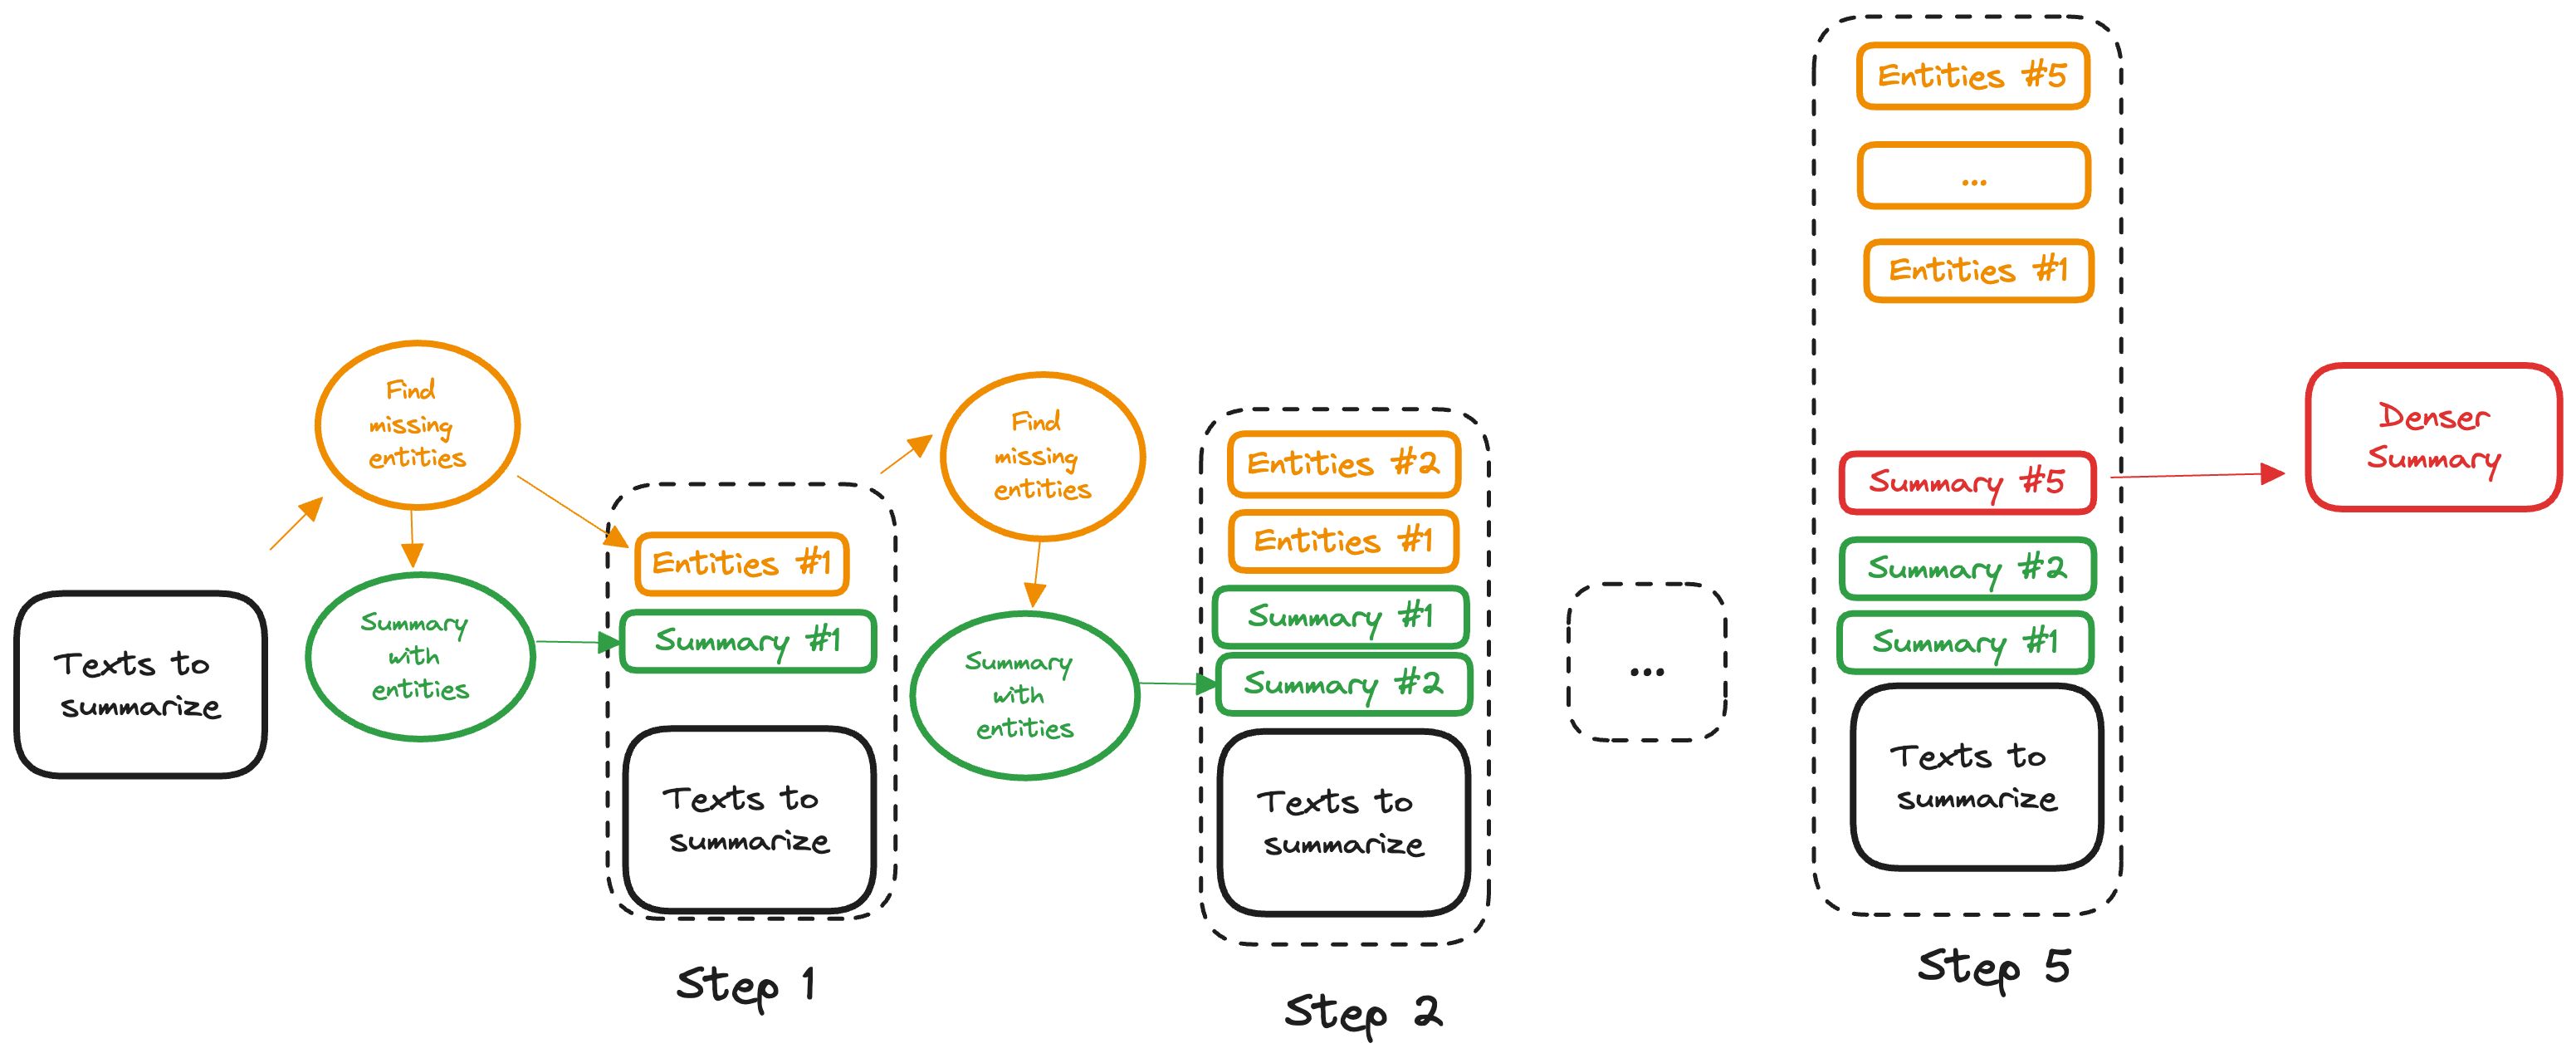

In [28]:
cod_prompt = """
Human:
Reviews: `{text}`
You will generate increasingly concise, entity-dense summaries of the above list of reviews.

Repeat the following 2 steps 5 times.
Step 1. Identify 1-3 informative entities (";" delimited) from the review which are missing from the previously generated summary.
Step 2. Write a new, denser summary of identical length which covers every entity and detail from the previous summary plus the missing entities.
A missing entity is:
- relevant to the main story,
- specific yet concise (5 words or fewer),
- novel (not in the previous summary),
- faithful (present in the reviews),
- anywhere (can be located anywhere in the review).
Guidelines:
- The first summary should be long (4-5 sentences, ~80 words) yet highly non-specific, containing little information beyond the entities marked as missing. Use overly verbose language and fillers (e.g., "these reviews discuss") to reach ~80 words.
- Make every word count: rewrite the previous summary to improve flow and make space for additional entities.
- Make space with fusion, compression, and removal of uninformative phrases like "the rveiws discuss".
- The summaries should become highly dense and concise yet self-contained, i.e., easily understood without the reviews.
- Missing entities can appear anywhere in the new summary.
- Never drop entities from the previous summary. If space cannot be made, add fewer new entities.
Remember, use the exact same number of words for each summary.

Output only a JSON file, containing the key "summaries".
Value of "summaries" key is a list (length 5) of dictionaries whose keys are "Missing_Entities" and "Denser_Summary".

JSON file will be between '<json>' and '</json>' words.
Assistant:
"""

In [25]:
from langchain.prompts import PromptTemplate

map_prompt_template= PromptTemplate(input_variables = ['text'], template=cod_prompt)


In [26]:
from langchain.chains.summarize import load_summarize_chain
cod_summary_chain = load_summarize_chain(llm=llm, chain_type="stuff", verbose=True, prompt=map_prompt_template,)

In [29]:
cod_output = ""
try:

    cod_output = cod_summary_chain.run(docs)

except ValueError as error:
    if  "AccessDeniedException" in str(error):
        print(f"\x1b[41m{error}\
        \nTo troubeshoot this issue please refer to the following resources.\
         \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
         \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")
        class StopExecution(ValueError):
            def _render_traceback_(self):
                pass
        raise StopExecution
    else:
        raise error



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Reviews: `The Good, the Bad and the Ugly is, without a doubt, a pinnacle of cinematic achievement. Sergio Leone's direction in this film is nothing short of visionary. The way he utilizes the vast, arid landscapes to create a sense of both isolation and grandeur is masterful. Ennio Morricone's score is a character in itself, evoking emotions that words alone cannot express. Clint Eastwood's portrayal of the 'Man with No Name' is iconic, displaying a stoic coolness that defines a generation of anti-heroes. The film's final standoff is a tense, nail-biting climax, and the way it's shot, with extreme close-ups and drawn-out silences, keeps you on the edge of your seat.

Sergio Leone's The Good, the Bad and the Ugly stands as a monumental achievement in the realm of spaghetti westerns. The film is a captivating journey through the unforgiving and lawless landscapes of the American fro

In [45]:
from IPython.display import display, Markdown
json_output = json.loads(cod_output.split('<json>')[1].split('</json>')[0])

for i,v in enumerate(json_output):
    display(Markdown(f"### Step {i+1}:"))
    display(Markdown("_attempt summary_ : "+ v['Denser_Summary']))
    display(Markdown("_entities missing_: "+ v['Missing_Entities']))


### Step 1:

_attempt summary_ : These overly verbose reviews of excessive length discuss a Western film directed by Sergio Leone featuring a protagonist portrayed by Clint Eastwood.

_entities missing_: spaghetti western; Clint Eastwood; iconic

### Step 2:

_attempt summary_ : These reviews of The Good, the Bad and the Ugly, a spaghetti western directed by Sergio Leone, praise the iconic performance by Clint Eastwood and the memorable score by Ennio Morricone.

_entities missing_: Ennio Morricone; score

### Step 3:

_attempt summary_ : The reviews praise director Sergio Leone's use of cinematography to capture the western landscapes as well as Clint Eastwood's iconic portrayal and Ennio Morricone's memorable score in this classic spaghetti western The Good, the Bad and the Ugly.

_entities missing_: cinematography; landscapes

### Step 4:

_attempt summary_ : These reviews highlight standout aspects of the classic spaghetti western The Good, the Bad and the Ugly including director Sergio Leone's cinematography, Clint Eastwood's iconic portrayal, Ennio Morricone's score, the moral ambiguity, and the climactic three-way standoff.

_entities missing_: moral ambiguity; climax

### Step 5:

_attempt summary_ : While praising the cinematography, iconic lead performance, and classic score, the reviews express some mixed feelings about the pacing and lengthy runtime of Sergio Leone's classic yet polarizing spaghetti western The Good, the Bad and the Ugly.

_entities missing_: pacing; mixed feelings

In [38]:
v.keys()

dict_keys(['Missing_Entities', 'Denser_Summary'])

### Let's do the same with Martin Scorsese's _The Departed_

In [46]:
with open('.//data/the_departed.json') as fp:
    reviews = json.loads(fp.read())['reviews']

from langchain.docstore.document import Document
docs= []
for review in reviews:
    md = review.copy()
    md.pop('text')
    md['nb_tokens']=llm.get_num_tokens(review['text'])
    doc = Document(page_content=review['text'], metadata=md)
    docs.append(doc)

In [47]:
cod_output = ""
try:

    cod_output = cod_summary_chain.run(docs)

except ValueError as error:
    if  "AccessDeniedException" in str(error):
        print(f"\x1b[41m{error}\
        \nTo troubeshoot this issue please refer to the following resources.\
         \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
         \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")
        class StopExecution(ValueError):
            def _render_traceback_(self):
                pass
        raise StopExecution
    else:
        raise error



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Reviews: `The Departed is a masterpiece of crime cinema. Martin Scorsese's direction is nothing short of brilliant, and the film's stellar cast, including Leonardo DiCaprio, Matt Damon, and Jack Nicholson, deliver outstanding performances. The cat-and-mouse game between the Boston police and the mob keeps you on the edge of your seat throughout. The film's tension and suspense are perfectly balanced with moments of dark humor. It's a crime thriller that stands the test of time.

The Departed is a gripping crime drama with a complex narrative and a web of intriguing characters. Martin Scorsese once again proves his mastery of the genre. The performances by DiCaprio and Damon are exceptional, and Jack Nicholson's portrayal of the unpredictable gangster is iconic. While the film keeps you engaged, it can be a bit convoluted at times, but it's a minor flaw in an otherwise outstanding 

In [48]:
from IPython.display import display, Markdown
json_output = json.loads(cod_output.split('<json>')[1].split('</json>')[0])
for i,j in enumerate(json_output):
    display(Markdown(f"""## Step {i+1}"""))
    display(Markdown(f"""### New entities"""))
    display(Markdown(j['Missing_Entities']))
    display(Markdown(f"""### Summary"""))
    display(Markdown(j['Denser_Summary']))

## Step 1

### New entities

;Martin Scorsese's direction;stellar cast

### Summary

These reviews discuss the film The Departed, which received critical acclaim. The summary contains ~80 words to avoid specifics.

## Step 2

### New entities

;crime thriller;Boston;intricate plot

### Summary

These reviews praise The Departed, Martin Scorsese's masterfully directed crime thriller set in Boston, for its stellar cast performances and intricate plot despite some criticisms of convoluted storytelling.

## Step 3

### New entities

;Leonardo DiCaprio;Matt Damon;Jack Nicholson

### Summary

The Departed, Martin Scorsese's masterfully directed crime thriller set in Boston, stars Leonardo DiCaprio, Matt Damon, and Jack Nicholson in a stellar cast praised for performances in an intricate, though sometimes convoluted plot.

## Step 4

### New entities

;cat-and-mouse game;rollercoaster

### Summary

Scorsese masterfully directs The Departed, a stellar-cast crime thriller starring DiCaprio, Damon, and Nicholson in a complex cat-and-mouse plot providing an intense rollercoaster, despite some convoluted storytelling.

## Step 5

### New entities

;dark humor;moral ambiguity

### Summary

Scorsese's masterful direction of The Departed creates an intense, stellar-cast rollercoaster with DiCaprio, Damon, and Nicholson in a complex cat-and-mouse crime thriller marked by dark humor and moral ambiguity, though its intricate plot can be convoluted.

## Let's try with Llama

In [65]:
from langchain.llms.bedrock import Bedrock


cod_prompt = """
Human:
Reviews: `{text}`
You will generate increasingly concise, entity-dense summaries of the above list of reviews.

Repeat the following 2 steps 5 times.
Step 1. Identify 1-3 informative entities (";" delimited) from the review which are missing from the previously generated summary.
Step 2. Write a new, denser summary of identical length which covers every entity and detail from the previous summary plus the missing entities.
A missing entity is:
- relevant to the main story,
- specific yet concise (5 words or fewer),
- novel (not in the previous summary),
- faithful (present in the reviews),
- anywhere (can be located anywhere in the review).
Guidelines:
- The first summary should be long (4-5 sentences, ~80 words) yet highly non-specific, containing little information beyond the entities marked as missing. Use overly verbose language and fillers (e.g., "these reviews discuss") to reach ~80 words.
- Make every word count: rewrite the previous summary to improve flow and make space for additional entities.
- Make space with fusion, compression, and removal of uninformative phrases like "the rveiws discuss".
- The summaries should become highly dense and concise yet self-contained, i.e., easily understood without the reviews.
- Missing entities can appear anywhere in the new summary.
- Never drop entities from the previous summary. If space cannot be made, add fewer new entities.
Remember, use the exact same number of words for each summary.

Output only a JSON file, containing the key "summaries".
Value of "summaries" key is a list (length 5) of dictionaries whose keys are "Missing_Entities" and "Denser_Summary".

JSON file will be between '<json>' and '</json>' words.
"""

modelId = 'cohere.command-text-v14' #
cohere_llm = Bedrock(
    model_id=modelId,
    model_kwargs={
        "prompt":map_prompt_template,
        "max_tokens": 3000,
    "temperature": 0.2
    },
    client=bedrockruntime)

In [66]:
from langchain.chains.summarize import load_summarize_chain
cohere_cod_summary_chain = load_summarize_chain(llm=cohere_llm, chain_type="stuff", verbose=True, prompt=map_prompt_template)
cohere_summary_chain = load_summarize_chain(llm=cohere_llm, chain_type="stuff", verbose=True)

In [67]:
cohere_raw_output = cohere_summary_chain.run(docs)



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"The Departed is a masterpiece of crime cinema. Martin Scorsese's direction is nothing short of brilliant, and the film's stellar cast, including Leonardo DiCaprio, Matt Damon, and Jack Nicholson, deliver outstanding performances. The cat-and-mouse game between the Boston police and the mob keeps you on the edge of your seat throughout. The film's tension and suspense are perfectly balanced with moments of dark humor. It's a crime thriller that stands the test of time.

The Departed is a gripping crime drama with a complex narrative and a web of intriguing characters. Martin Scorsese once again proves his mastery of the genre. The performances by DiCaprio and Damon are exceptional, and Jack Nicholson's portrayal of the unpredictable gangster is iconic. While the film keeps you engaged, it can be a bit convoluted at times, but it's a minor

In [68]:
cohere_cod_output = cohere_cod_summary_chain.run(docs)



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Reviews: `The Departed is a masterpiece of crime cinema. Martin Scorsese's direction is nothing short of brilliant, and the film's stellar cast, including Leonardo DiCaprio, Matt Damon, and Jack Nicholson, deliver outstanding performances. The cat-and-mouse game between the Boston police and the mob keeps you on the edge of your seat throughout. The film's tension and suspense are perfectly balanced with moments of dark humor. It's a crime thriller that stands the test of time.

The Departed is a gripping crime drama with a complex narrative and a web of intriguing characters. Martin Scorsese once again proves his mastery of the genre. The performances by DiCaprio and Damon are exceptional, and Jack Nicholson's portrayal of the unpredictable gangster is iconic. While the film keeps you engaged, it can be a bit convoluted at times, but it's a minor flaw in an otherwise outstanding 

In [69]:
cohere_cod_output

' {\n  "summaries": [\n    {\n      "Missing_Entities": "crime cinema | direction | cast | performances | genre | crime | mob | police | suspense | dark humor | crime thriller | modern classic | direction | genre | performances | plot | twists | characters | moral dilemmas | intense | suspenseful | gritty | mastery | genre | performances | intricacy | complex | solid | convoluted | confusion | critical acclaim",\n      "Denser_Summary": "The Departed is a crime thriller praised for its direction and ensemble cast. The performances, direction, and genre are all highlighted as exemplary. The film\'s complexity, including its web of characters and plot, is noted, although some reviews mention confusion due to its convoluted nature. The Departed\'s critical acclaim is also mentioned."\n    },\n    {\n      "Missing_Entities": "Martin Scorsese | Leonardo DiCaprio | Matt Damon | Jack Nicholson",\n      "Denser_Summary": "Martin Scorsese\'s direction, and the performances of Leonardo DiCaprio

In [70]:
summaries = json.loads(cohere_cod_output.strip().replace('\n','').replace('</json>', ''))['summaries']
for i,j in enumerate(summaries):
    display(Markdown(f"""## Step {i+1}"""))
    display(Markdown(f"""### New entities"""))
    display(Markdown(j['Missing_Entities']))
    display(Markdown(f"""### Summary"""))
    display(Markdown(j['Denser_Summary']))

## Step 1

### New entities

crime cinema | direction | cast | performances | genre | crime | mob | police | suspense | dark humor | crime thriller | modern classic | direction | genre | performances | plot | twists | characters | moral dilemmas | intense | suspenseful | gritty | mastery | genre | performances | intricacy | complex | solid | convoluted | confusion | critical acclaim

### Summary

The Departed is a crime thriller praised for its direction and ensemble cast. The performances, direction, and genre are all highlighted as exemplary. The film's complexity, including its web of characters and plot, is noted, although some reviews mention confusion due to its convoluted nature. The Departed's critical acclaim is also mentioned.

## Step 2

### New entities

Martin Scorsese | Leonardo DiCaprio | Matt Damon | Jack Nicholson

### Summary

Martin Scorsese's direction, and the performances of Leonardo DiCaprio, Matt Damon, and Jack Nicholson, are all praised in the reviews of the crime thriller The Departed. The film's genre and the moral dilemmas of its characters are highlighted.

## Step 3

### New entities

the Departed's plot

### Summary

The Departed's convoluted plot leads to confusion and disappointment in some viewers, despite the strong direction and performances of the cast. The film's critical acclaim is also mentioned.

## Step 4

### New entities

The Departed's status

### Summary

The Departed is a modern classic, a triumph, and a masterpiece of the crime genre, with a complex web of plot and character.

## Conclusion

👉🏽 Summarization is a professional use-case that can be harnessed by generative AI, with proper guardrails.

👉🏽 Efficient prompt design can improve the quality of the output

👉🏽 "Bigger" models are not always better: no one-size-fits-all solution

👉🏽 A *sine qua non* condition to scalability is consistency. Therefore, builders must heavily stress tests the generated outputs from the LLM before putting in production.


👉🏽 AI can hallucinate by finding drawbacks within Scorsese's cinematography 🤷🏻‍♂️



